In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
df = pd.read_csv('combined_csv_wealthmanagement.csv')
df.head()

,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink
0,2019-12-31 23:45:02,HT_Great_Lakes,NaN,0,1,1,Thinking about transitioning your business? Yo...,NaN,NaN,#wealthmanagement #hightowergreatlakes #busine...,1212157749250924544,https://twitter.com/HT_Great_Lakes/status/1212...
1,2019-12-31 23:31:32,ripsawwealth,NaN,0,2,3,http://RipsawWealth.com #2020WillBeTheYearFor ...,NaN,NaN,#2020WillBeTheYearFor #HappyNewYear #happynewy...,1212154351281508352,https://twitter.com/ripsawwealth/status/121215...
2,2019-12-31 23:00:40,TedHunter1,NaN,0,0,0,#wealthmanagement #maxous,NaN,NaN,#wealthmanagement #maxous,1212146581950128134,https://twitter.com/TedHunter1/status/12121465...
3,2019-12-31 22:45:05,RAlexJimenez,NaN,0,0,0,#WealthManagement and private banking trends: ...,NaN,@FinTechMagazine,#WealthManagement #wealthtech #fintech #finserv,1212142660053557249,https://twitter.com/RAlexJimenez/status/121214...
4,2019-12-31 22:43:01,findadvisor,NaN,0,0,0,Is Your Money Ready for Retirement? #Retiremen...,NaN,NaN,#RetirementPlan #FinancialPlan #WealthManageme...,1212142141780054016,https://twitter.com/findadvisor/status/1212142...


In [3]:
df_tweets = df[["date","text"]]
df_tweets

,date,text
0,2019-12-31 23:45:02,Thinking about transitioning your business? Yo...
1,2019-12-31 23:31:32,http://RipsawWealth.com #2020WillBeTheYearFor ...
2,2019-12-31 23:00:40,#wealthmanagement #maxous
3,2019-12-31 22:45:05,#WealthManagement and private banking trends: ...
4,2019-12-31 22:43:01,Is Your Money Ready for Retirement? #Retiremen...
...,...,...
32861,2019-02-13 01:15:03,.@Praemium said its major technology upgrade w...
32862,2019-02-13 01:13:06,A Seismic Shift in the Estate-Planning Landsca...
32863,2019-02-13 01:11:01,"Interview: Scott Cooper, @CybiWealth – investi..."
32864,2019-02-13 01:06:01,How much are you worth? . . . . #wealth #Wealt...


In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import nltk
nltk.download('stopwords')
import pandas as pd
import re
import math

def clean_tweets(df=df_tweets, 
                 tweet_col='text', 
                 date_col='date'
                ):
    
    df_copy = df.copy()
    
    # drop rows with empty values
    df_copy.dropna(inplace=True)
    
    # lower the tweets
    df_copy['preprocessed_' + tweet_col] = df_copy[tweet_col].str.lower()
    
    # filter out stop words and URLs
    en_stop_words = stopwords.words('english')
    extended_words = ['&amp;', 'rt','th','co', 're', 've', 'kim', 'daca', '#wealthmanagement', 'wealthmanagement', 'de', 'la', 'en', 'ria', 'di', 'el', 'ask', 'un', 'con', 'per', 'del', 'help', 'you', 'via', 'us', 'gt', 'ai', 'cx']
    en_stop_words.extend(extended_words)
    en_stop_words = set(en_stop_words)
    url_re = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'        
    df_copy['preprocessed_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: ' '.join([word for word in row.split() if (not word in en_stop_words) and (not re.match(url_re, word))]))
    
    # tokenize the tweets
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df_copy['tokenized_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: tokenizer.tokenize(row))
    
    return df_copy
  
df_tweets_clean = clean_tweets(df_tweets)
df_tweets_clean.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aditya.baser\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,date,text,preprocessed_text,tokenized_text
0,2019-12-31 23:45:02,Thinking about transitioning your business? Yo...,thinking transitioning business? you’ll surpri...,"[thinking, transitioning, business, you, ll, s..."
1,2019-12-31 23:31:32,http://RipsawWealth.com #2020WillBeTheYearFor ...,#2020willbetheyearfor financial control! #happ...,"[willbetheyearfor, financial, control, happyne..."
2,2019-12-31 23:00:40,#wealthmanagement #maxous,#maxous,[maxous]
3,2019-12-31 22:45:05,#WealthManagement and private banking trends: ...,private banking trends: 2020 | @fintechmagazin...,"[private, banking, trends, fintechmagazine, we..."
4,2019-12-31 22:43:01,Is Your Money Ready for Retirement? #Retiremen...,money ready retirement? #retirementplan #finan...,"[money, ready, retirement, retirementplan, fin..."


In [10]:
def get_most_freq_words(str, n=None):
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)
    sum_words = bag_of_words.sum(axis=0) 
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq =sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]
  
get_most_freq_words([ word for tweet in df_tweets_clean.tokenized_text for word in tweet],10)

[('wealth', 7252),
 ('investing', 4369),
 ('financialplanning', 4013),
 ('investment', 3616),
 ('fintech', 3313),
 ('financial', 3233),
 ('money', 2969),
 ('retirement', 2796),
 ('management', 2551),
 ('finance', 2484)]

In [11]:
# build a dictionary where for each tweet, each word has its own id.
# We have 6882 tweets and 10893 words in the dictionary.
tweets_dictionary = Dictionary(df_tweets_clean.tokenized_text)

# build the corpus i.e. vectors with the number of occurence of each word per tweet
tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in df_tweets_clean.tokenized_text]

## Do not Run the below Cell - Takes 45 mins to run

ValueError: x and y must have same first dimension, but have shapes (35,) and (24,)

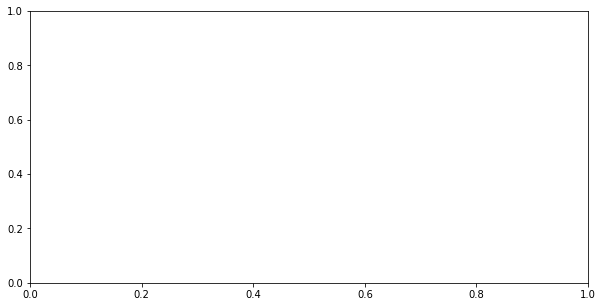

In [6]:
# compute coherence
tweets_coherence = []
for nb_topics in range(1,25):
    lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = tweets_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)

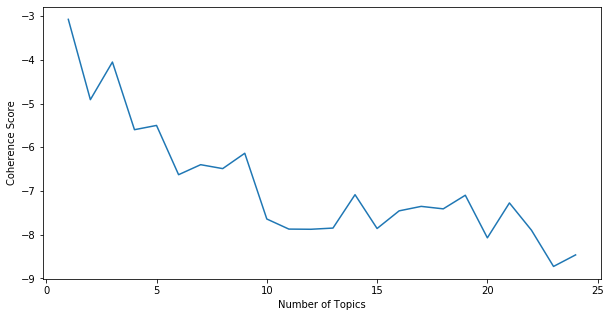

In [8]:
# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,25),tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

In [16]:
k = 13
tweets_lda = LdaModel(tweets_corpus, num_topics = k, id2word = tweets_dictionary, passes=10)

def plot_top_words(lda=tweets_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

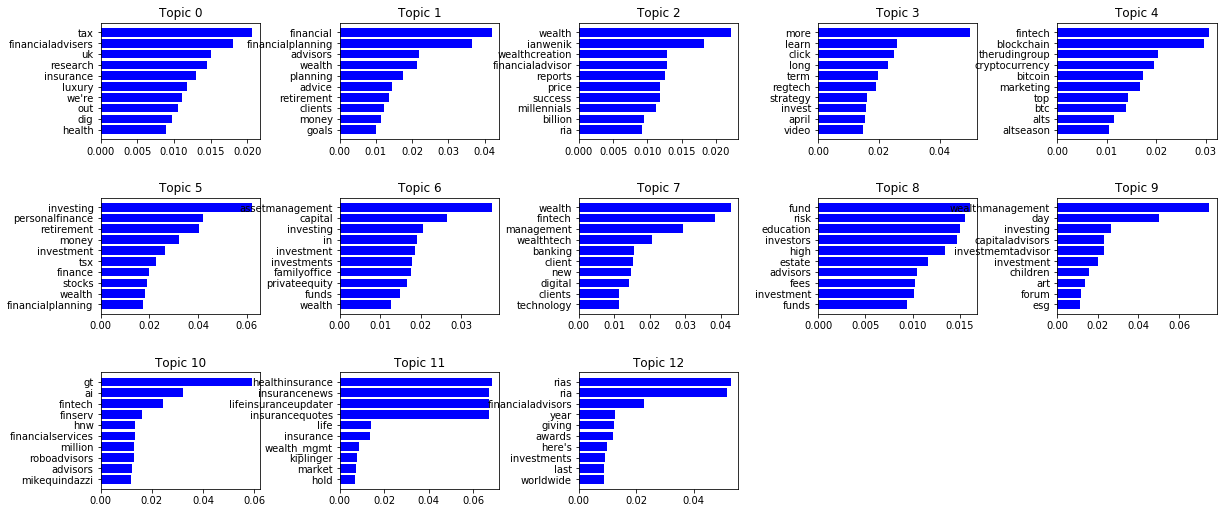

In [17]:
import matplotlib.gridspec as gridspec
plot_top_words()

In [833]:
list_ = []
for i in range(len(df_tweets_clean)):
    x = tweets_lda[tweets_corpus[i]]
    for j in range(len(x)):
        if x[j][1] == max(dict(x).values()):
            list_.append('Topic'+str(x[j][0] + 1))
            break
print(len(list_))

32866


In [847]:
dict(tweets_lda[tweets_corpus[32865]])

{5: 0.82239646, 9: 0.100669175}

In [834]:
df_tweets_clean["Label"] = list_
df_tweets_clean.head()

,date,text,preprocessed_text,tokenized_text,Label
0,2019-12-31 23:45:02,Thinking about transitioning your business? Yo...,thinking transitioning business? you’ll surpri...,"[thinking, transitioning, business, you, ll, s...",Topic2
1,2019-12-31 23:31:32,http://RipsawWealth.com #2020WillBeTheYearFor ...,#2020willbetheyearfor financial control! #happ...,"[willbetheyearfor, financial, control, happyne...",Topic2
2,2019-12-31 23:00:40,#wealthmanagement #maxous,#maxous,[maxous],Topic11
3,2019-12-31 22:45:05,#WealthManagement and private banking trends: ...,private banking trends: 2020 | @fintechmagazin...,"[private, banking, trends, fintechmagazine, we...",Topic8
4,2019-12-31 22:43:01,Is Your Money Ready for Retirement? #Retiremen...,money ready retirement? #retirementplan #finan...,"[money, ready, retirement, retirementplan, fin...",Topic6


In [529]:
list_ = []
for i in range(5):
    ie = []
    for j in range(len(tweets_lda[tweets_corpus[i]])):
        ie.append(round(tweets_lda[tweets_corpus[1]][j][1], 2))
    for j in range(len(tweets_lda[tweets_corpus[i]])):
        if tweets_lda[tweets_corpus[i]][j][1] == max(ie):
            print(tweets_lda[tweets_corpus[i]][j][1])
            list_.append('Topic'+str(tweets_lda[corpus[i]][j][0] + 1))

In [18]:
pip install wikiapi

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install pattern

  Created wheel for pattern: filename=Pattern-3.6-py3-none-any.whl size=22332728 sha256=bc8dc014155302d876279251ab9880187812cee110061ed3a83b2abd11be430b
  Stored in directory: c:\users\aditya.baser\appdata\local\pip\cache\wheels\8d\1f\4e\9b67afd2430d55dee90bd57618dd7d899f1323e5852c465682
  Created wheel for feedparser: filename=feedparser-5.2.1-py3-none-any.whl size=44944 sha256=53a2a3a9039b8b063e7262abb6e359fa30b5d2ddf05b79d252444d7ca6174b13
  Stored in directory: c:\users\aditya.baser\appdata\local\pip\cache\wheels\4a\87\a9\ef99b7b68f9816d5ef1262dc11ce31a93a844eb69e68c1a031
  Created wheel for python-docx: filename=python_docx-0.8.10-py3-none-any.whl size=184495 sha256=9771e8ea71385313dd6bec65f1efd06763296e83e6338ddf1409f5cb218827c6
  Stored in directory: c:\users\aditya.baser\appdata\local\pip\cache\wheels\75\c6\69\05491f32dc052cd70476b65f5bf7082a9b274045f6b001b821
Successfully built pattern feedparser python-docx
Note: you may need to restart the kernel to use updated packages.


In [24]:
from wikiapi import WikiApi
import gensim
from gensim.utils import simple_preprocess, lemmatize
import pattern 
def get_relevant_articles(keywords, search_depth=5, keyword_summary=5):
    """
    Searches through a list of keywords and returns keywords based on article headers
    in Wikipedia.    

    args:
    *  keywords: A list of keywords
    *  search_depth: how many wikipedia search results are checked, assumes to be between 1-10
    *  keyword_summary: gensim word argument to how many words should be used in summarization
    """
    if len(keywords) == 0:
        return []
    wiki = WikiApi()

    keywords = [x.lower() for x in keywords]
    info = []
    for keyword in keywords:
        results = wiki.find(keyword)
        other_words = [x for x in keywords if x != keyword]
        
        if search_depth is not None:
            results = results[:search_depth]

        for result in results:
            article = wiki.get_article(result)
            summary_words = article.summary.lower().split(' ')
            has_words = any(word in summary_words for word in other_words)

            if has_words:
                info.append(article.heading)

    try:
        info_keyword = gensim.summarization.keywords(' '.join(info),
                    words=keyword_summary).split('\n')
    except:
        print("keyword extraction failed, defaulting to article heading output")
        info_keyword = info[:]
    return info_keyword

In [27]:
all_results = get_relevant_articles("financial financialplanning advisors wealth planning advice retirement clients money goals".split())
print(all_results)

['financial', 'planning', 'plans', 'money', 'wealth', 'retirement']


In [28]:
texts = list(df_tweets_clean["tokenized_text"])

In [29]:
def convert_list_to_string(list_, separator = ' '):
    tweetss = []
    for i in list_:
        tweetss.append(separator.join(i))
    return tweetss

tweetss = convert_list_to_string(texts, separator = ' ')
df_clean = pd.DataFrame(tweetss, columns = ['tweets'])
df_clean.head()

,tweets
0,thinking transitioning business you ll surpris...
1,willbetheyearfor financial control happynewyea...
2,maxous
3,private banking trends fintechmagazine wealtht...
4,money ready retirement retirementplan financia...


In [30]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS

In [31]:
#Set parameters
num_topics = 5 #The number of topics that should be generated
passes = 10
dictionary = corpora.Dictionary(texts) #(word_id,word) pairs
corpus = [dictionary.doc2bow(text) for text in texts] #(word_id,freq) pairs by sentence

In [34]:
lda = LdaModel(corpus,
              id2word=dictionary,
              num_topics=num_topics,
              passes=passes)

In [74]:
lda[corpus[len(texts)-1]]

[(0, 0.0183024),
 (1, 0.15820244),
 (2, 0.018299848),
 (3, 0.018232325),
 (4, 0.786963)]

In [ ]:
ie = []
for j in range(num_topics):
    ie.append(lda[corpus[0]][j][1])
    if lda[corpus[0]][j][1] == max(ie):
        list_.append('Topic'+str(lda[corpus[0]][j][0] + 1))

In [146]:
list_ = []

for i in range(20):
    if len(lda[corpus[i]]) == 5:
        ie = []
        for j in range(num_topics):
            ie.append(lda[corpus[i]][j][1])
        for j in range(num_topics):
            if lda[corpus[i]][j][1] == max(ie):
                list_.append('Topic'+str(lda[corpus[i]][j][0] + 1))
    else:
        list_.append('0')
print(list_)

['Topic3', 'Topic1', '0']


In [124]:
len(list_)

25861

In [18]:
def draw_wordcloud(lda,topicnum,min_size=0,STOPWORDS=[]):
    word_list=[]
    prob_total = 0
    for word,prob in lda.show_topic(topicnum,topn=50):
        prob_total +=prob
    for word,prob in lda.show_topic(topicnum,topn=50):
        if word in STOPWORDS or  len(word) < min_size:
            continue
#         freq = int(prob/prob_total*1000)
        freq = int(prob/prob_total*100)
        alist=[word]
        word_list.extend(alist*freq)
        
#     print(word_list)
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    %matplotlib inline
    from random import shuffle
    shuffle(word_list)
    text = ' '.join(word_list)
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',max_words=20).generate(text)

    plt.axis('off')
    plt.imshow(wordcloud)

    return None

In [ ]:
draw_wordcloud(lda,0)

In [51]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)